Jumlah data: 3795
⚠️ Dataset masih kurang dari 10.000! Tambahkan lebih banyak data.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/s2idev/nltk_data...


✅ SVM Best Params: {'C': 10, 'kernel': 'rbf'}
✅ SVM Accuracy: 90.09%
✅ Random Forest Accuracy: 88.39%


/Users/s2idev/PycharmProjects/SentimenReviewApplicationInstagram/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4761 - loss: 1.0360 - val_accuracy: 0.5867 - val_loss: 1.0809 - learning_rate: 1.0000e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6063 - loss: 0.9055 - val_accuracy: 0.5929 - val_loss: 1.0607 - learning_rate: 1.0000e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6902 - loss: 0.7783 - val_accuracy: 0.6006 - val_loss: 1.0070 - learning_rate: 1.0000e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7907 - loss: 0.6217 - val_accuracy: 0.6641 - val_loss: 0.9839 - learning_rate: 1.0000e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8235 - loss: 0.5129 - val_accuracy: 0.7570 - val_loss: 0.9280 - learning_rate: 1.0000e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8855 - loss: 0.3275 - val_accuracy: 0.7616 - val_loss: 0.8204 - learning_rate: 1.0000e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9443 - loss:

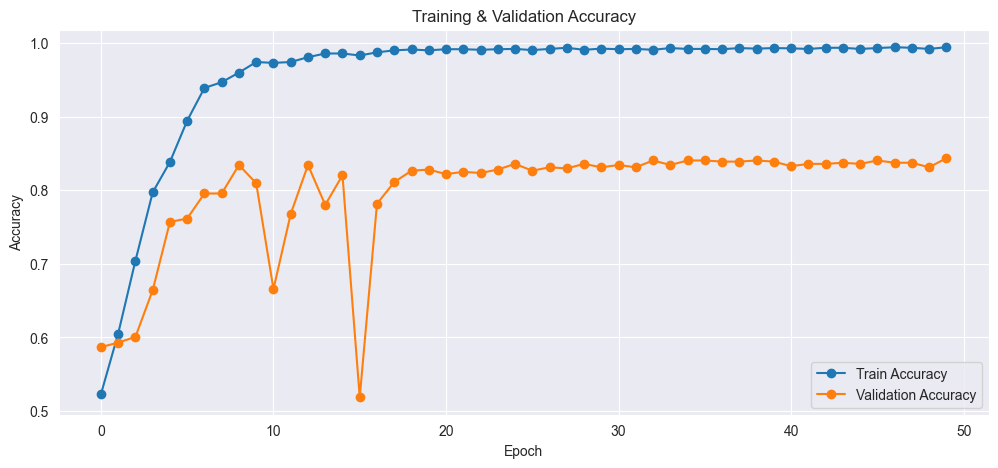

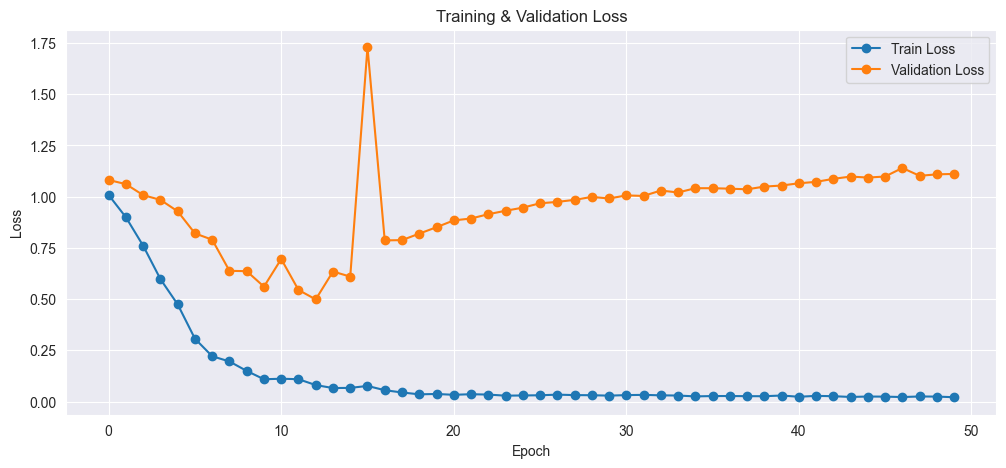

In [2]:
# 📌 Import Library
import os
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 📌 Load Dataset
df = pd.read_csv("data/news_scraping_results.csv")

# ✅ Cek jumlah data
print(f"Jumlah data: {len(df)}")
if len(df) < 10000:
    print("⚠️ Dataset masih kurang dari 10.000! Tambahkan lebih banyak data.")

# 📌 Data Cleaning
df = df.dropna().reset_index(drop=True)

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df['clean_content'] = df['content'].apply(clean_text)

# 📌 Sentiment Labeling
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_content'].apply(get_sentiment)

# 📌 Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], df['sentiment'], test_size=0.2, random_state=42)

# ✅ TF-IDF Vectorization untuk SVM dan RF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# ✅ Model 1: Support Vector Machine (SVM)
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_model = GridSearchCV(SVC(), svm_params, cv=5)
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)
svm_acc = accuracy_score(y_test, svm_preds)
print("✅ SVM Best Params:", svm_model.best_params_)
print("✅ SVM Accuracy:", f"{svm_acc:.2%}")

# ✅ Model 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
rf_preds = rf_model.predict(X_test_tfidf)
rf_acc = accuracy_score(y_test, rf_preds)
print("✅ Random Forest Accuracy:", f"{rf_acc:.2%}")

# ✅ Model 3: Optimized LSTM
max_words = 15000  # Tambah jumlah kata unik
max_len = 250  # Panjang sequence

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# 🔹 LSTM Model dengan Hyperparameter Tuning
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(256, return_sequences=True)),
    BatchNormalization(),
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# 🔹 Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# 🔹 Training Model LSTM
history = model.fit(X_train_seq, y_train.factorize()[0], epochs=50, batch_size=64, validation_data=(X_test_seq, y_test.factorize()[0]), callbacks=[lr_scheduler])

# 🔹 Evaluasi Model
lstm_accuracy = model.evaluate(X_test_seq, y_test.factorize()[0], verbose=0)[1]
print("✅ LSTM Accuracy setelah tuning:", f"{lstm_accuracy:.2%}")

# 🔹 Menampilkan Hasil Evaluasi
print("\n🔹 Evaluasi Model:")
print(f"SVM Accuracy: {svm_acc:.2%}")
print(f"Random Forest Accuracy: {rf_acc:.2%}")
print(f"LSTM Accuracy: {lstm_accuracy:.2%}")

# 🔹 Contoh Prediksi Model LSTM
print("\n🔹 Contoh Prediksi:")
sample_texts = X_test[:5].tolist()
sample_labels = y_test[:5].tolist()
sample_preds = model.predict(pad_sequences(tokenizer.texts_to_sequences(sample_texts), maxlen=max_len))

for i, text in enumerate(sample_texts):
    print(f"Kalimat: {text}")
    print(f"Label Asli: {sample_labels[i]}")
    print(f"Prediksi Model: {['negative', 'neutral', 'positive'][np.argmax(sample_preds[i])]}\n")

# 🔹 Visualisasi Akurasi Model
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Visualisasi Loss Model
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
